In [ ]:
# !pip install catboost # 지금 모델은 XGBoost만 사용

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00


In [ ]:
# 라이브러리 불러오기
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/DACON/암환자 유전체 데이터/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DACON/암환자 유전체 데이터/test.csv")

# 성능 높이기 위한 시도

# 작동되는 코드

In [ ]:
# # 1. SUBCLASS에 암종 이름이 있는지 확인
# print(train['SUBCLASS'].unique())  # 암종 이름이 출력되는지 확인

In [ ]:
# 1. SUBCLASS에 LabelEncoder 적용
le_subclass = LabelEncoder()
train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# LabelEncoder로 변환된 클래스 확인 (암종 이름)
print("LabelEncoder classes:", le_subclass.classes_)

LabelEncoder classes: ['ACC' 'BLCA' 'BRCA' 'CESC' 'COAD' 'DLBC' 'GBMLGG' 'HNSC' 'KIPAN' 'KIRC'
 'LAML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'OV' 'PAAD' 'PCPG' 'PRAD' 'SARC' 'SKCM'
 'STES' 'TGCT' 'THCA' 'THYM' 'UCEC']


## - 아래 코드는 꼭 필요

In [ ]:
# 3. 학습 데이터에서 ID와 SUBCLASS를 제외한 유전자 정보만 사용
X_train = train.drop(columns=['ID', 'SUBCLASS'])
y_train = train['SUBCLASS']

# 4. 테스트 데이터에서 ID를 제외하고 유전자 정보만 사용
X_test = test.drop(columns=['ID'])

# 5. 유전자 변이 데이터를 0(WT), 1(변이 있음)으로 변환
X_train = X_train.replace({'WT': 0}).applymap(lambda x: 1 if x != 0 else 0)
X_test = X_test.replace({'WT': 0}).applymap(lambda x: 1 if x != 0 else 0)

# 6. 특정 암종에서의 동시 변이 패턴 강조
# GBMLGG 암종에서 IDH1과 ATRX 동시 변이가 중요한 역할을 하므로 이를 강조하는 피처 추가
X_train['GBMLGG_IDH1_ATRX'] = ((y_train == le_subclass.transform(['GBMLGG'])[0]) &
                               (X_train['IDH1'] == 1) &
                               (X_train['ATRX'] == 1))

# 테스트 데이터에서도 동일한 피처 추가
X_test['GBMLGG_IDH1_ATRX'] = (X_test['IDH1'] == 1) & (X_test['ATRX'] == 1)

# 7. 유전자 간 상호작용 피처 추가 (예: BRAF와 IDH1, TP53와 PIK3CA 상호작용)
X_train['BRAF_IDH1_interaction'] = X_train['BRAF'] * X_train['IDH1']
X_test['BRAF_IDH1_interaction'] = X_test['BRAF'] * X_test['IDH1']

X_train['TP53_PIK3CA_interaction'] = X_train['TP53'] * X_train['PIK3CA']
X_test['TP53_PIK3CA_interaction'] = X_test['TP53'] * X_test['PIK3CA']

# 8. IDH1과 ATRX 동시 변이를 반영한 상호작용 피처 추가
X_train['IDH1_ATRX_interaction'] = X_train['IDH1'] * X_train['ATRX']
X_test['IDH1_ATRX_interaction'] = X_test['IDH1'] * X_test['ATRX']

# 9. 변이 빈도 계산 및 피처로 추가
X_train['mutation_freq'] = X_train.mean(axis=1)
X_test['mutation_freq'] = X_test.mean(axis=1)


# 11. 변이 총합 계산
X_train['total_mutations'] = X_train.sum(axis=1)
X_test['total_mutations'] = X_test.sum(axis=1)


# 10. 새로운 피처: mutation_freq에 대한 피처 엔지니어링 (예: 상호작용 피처 및 비율 피처)
# mutation_freq가 중요한 피처로 밝혀졌으므로 이를 다른 피처와 결합하여 새로운 피처 생성
X_train['mutation_freq_ratio'] = X_train['mutation_freq'] / (X_train['total_mutations'] + 1)  # 변이 빈도 비율
X_test['mutation_freq_ratio'] = X_test['mutation_freq'] / (X_test['total_mutations'] + 1)

# mutation_freq와 다른 주요 피처 간 상호작용 피처 생성
X_train['mutation_freq_TP53_interaction'] = X_train['mutation_freq'] * X_train['TP53']
X_test['mutation_freq_TP53_interaction'] = X_test['mutation_freq'] * X_test['TP53']

# mutation_freq_ratio와 TP53 간 상호작용 피처 추가
X_train['mutation_freq_ratio_TP53_interaction'] = X_train['mutation_freq_ratio'] * X_train['TP53']
X_test['mutation_freq_ratio_TP53_interaction'] = X_test['mutation_freq_ratio'] * X_test['TP53']

# mutation_freq와 mutation_freq_ratio 간 상호작용 피처 생성
X_train['mutation_freq_and_ratio_interaction'] = X_train['mutation_freq'] * X_train['mutation_freq_ratio']
X_test['mutation_freq_and_ratio_interaction'] = X_test['mutation_freq'] * X_test['mutation_freq_ratio']

# TP53과 mutation_freq_ratio 간 상호작용을 다른 주요 유전자와 결합하여 강화
X_train['TP53_BRAF_interaction'] = X_train['TP53'] * X_train['BRAF']
X_test['TP53_BRAF_interaction'] = X_test['TP53'] * X_test['BRAF']

# 12. 훈련 데이터와 테스트 데이터의 피처 일치
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]


<ipython-input-12-4968fe20e3f0>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.replace({'WT': 0}).applymap(lambda x: 1 if x != 0 else 0)
<ipython-input-12-4968fe20e3f0>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train = X_train.replace({'WT': 0}).applymap(lambda x: 1 if x != 0 else 0)
<ipython-input-12-4968fe20e3f0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = X_test.replace({'WT': 0}).applymap(lambda x: 1 if x != 0 else 0)
<ipython-input-12-4968fe20e3

XGBoost Validation Accuracy: 0.5474559686888454
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       172
           1       0.66      0.68      0.67       147
           2       0.59      0.35      0.44       157
           3       0.35      0.40      0.37       160
           4       0.92      0.80      0.86       164
           5       0.65      0.74      0.70       163
           6       0.66      0.50      0.57       155
           7       0.53      0.49      0.51       156
           8       0.20      0.10      0.14       166
           9       0.39      0.34      0.36       151
          10       0.57      0.58      0.57       151
          11       0.76      0.77      0.76       160
          12       0.58      0.44      0.50       162
          13       0.70      0.47      0.56       154
          14       0.70      0.71      0.71       168
          15       0.42      0.48      0.45       163
          16       0.45      0.55

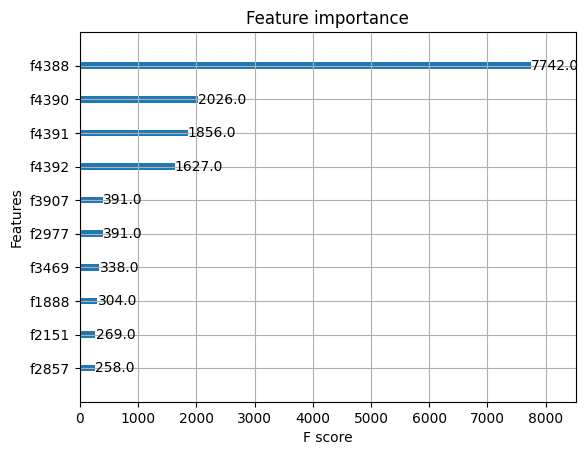

제출 파일이 성공적으로 생성되었습니다.


In [ ]:
# 13. 데이터 불균형 해결 (SMOTE)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 14. 데이터 분할 (훈련, 검증)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 15. 데이터 스케일링 (StandardScaler 사용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 16. XGBoost 모델 학습
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train_final)

# 17. 검증 데이터로 예측 및 성능 평가
y_pred_xgb = xgb_model.predict(X_val_scaled)
print(f"XGBoost Validation Accuracy: {accuracy_score(y_val, y_pred_xgb)}")
print(classification_report(y_val, y_pred_xgb))

# 18. 테스트 데이터 예측
test_predictions = xgb_model.predict(X_test_scaled)

# 19. 피처 중요도 시각화
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

# 20. 예측 결과를 다시 원래 SUBCLASS 레이블로 변환 (LabelEncoder로 복원)
original_labels = le_subclass.inverse_transform(test_predictions)

# 21. 제출 파일 생성 (원래 SUBCLASS 이름으로 변환된 결과 저장)
submission = pd.read_csv("/content/drive/MyDrive/DACON/암환자 유전체 데이터/sample_submission.csv")
submission["SUBCLASS"] = original_labels  # 예측된 이름을 SUBCLASS에 넣음
submission.to_csv('/content/drive/MyDrive/DACON/암환자 유전체 데이터/baseline7_submission.csv', encoding='UTF-8-sig', index=False)

print("제출 파일이 성공적으로 생성되었습니다.")

## - 특정 변이 정보 시각화

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 유전자 간 상호작용 (BRAF와 IDH1) 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(X_train[['BRAF', 'IDH1', 'TP53', 'PIK3CA']].corr(), annot=True, cmap='coolwarm')
plt.title('유전자 간 상관관계 히트맵')
plt.show()

'''
IDH1과 TP53의 상관관계는 약간 긍정적이며, 이 두 유전자는 특정 암종에서 함께 변이가 발생할 가능성을 시사합니다.
이러한 상호작용은 모델에서 중요한 예측 변수로 작용할 수 있습니다.
'''

NameError: name 'X_train' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
# 암종 이름으로 변환하여 그래프 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=le_subclass.inverse_transform(train['SUBCLASS']), y=X_train['mutation_freq'])  # 숫자를 암종 이름으로 변환
plt.title('암종별 mutation_freq 분포')
plt.xlabel('암종')
plt.ylabel('mutation_freq')
plt.xticks(rotation=45)
plt.show()

'''
GBMLGG, SARC, UCEC 등의 암종에서는 변이 빈도의 변동성이 크고,
특정 샘플에서는 변이 빈도가 매우 높은 이상치가 존재합니다.
'''

NameError: name 'X_train' is not defined

<Figure size 1000x600 with 0 Axes>

TypeError: no numeric data to plot

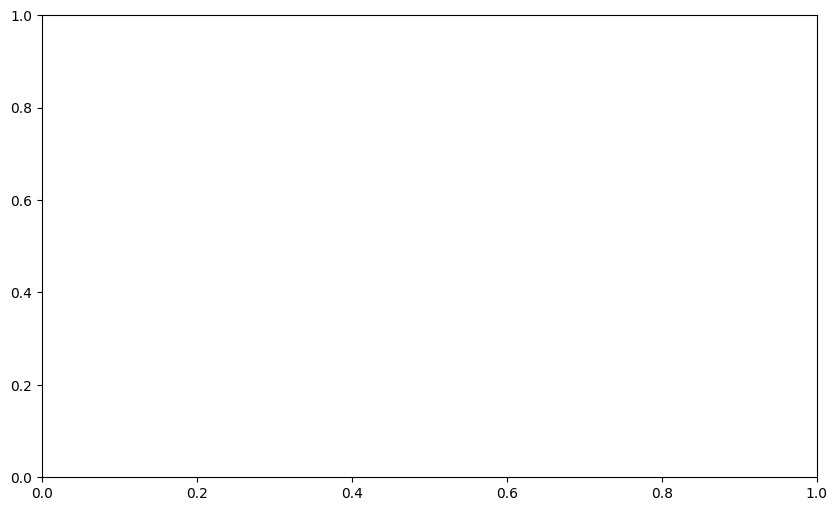

In [ ]:
# IDH1 변이 빈도 시각화
plt.figure(figsize=(10, 6))

# 암종 이름을 복원하고 IDH1 변이 빈도를 그룹화
mutation_counts = train.groupby('SUBCLASS')['IDH1'].sum().sort_values(ascending=False)
mutation_counts.index = le_subclass.inverse_transform(mutation_counts.index)  # 숫자를 암종 이름으로 변환

# 변이 빈도 시각화
mutation_counts.plot(kind='bar', color='skyblue')
plt.title('IDH1 변이 빈도 (암종별)')
plt.xlabel('암종')
plt.ylabel('IDH1 변이 수')
plt.xticks(rotation=45)
plt.show()

'''
이 그래프는 IDH1 변이가 특정 암종에서 특히 자주 발생하며,
특히 GBMLGG와 LGG에서 매우 중요한 바이오마커일 가능성을 보여줍니다.
이 변이 정보는 암종 분류 모델에서 중요한 피처로 사용될 수 있으며,
뇌암과 같은 특정 암종의 분류 성능을 향상시킬 수 있습니다.
'''

## - 중요한 인자 분석

In [ ]:
# X_train 또는 X_test에서 피처의 컬럼 이름을 확인
feature_names = X_train.columns  # 학습 데이터의 피처 이름 리스트

important_feature = feature_names[4388]
print(f"실제 피처 이름: {important_feature}")

실제 피처 이름: mutation_freq


In [ ]:
important_feature = feature_names[4390]
print(f"실제 피처 이름: {important_feature}")

실제 피처 이름: mutation_freq_ratio


In [ ]:
important_feature = feature_names[4391]
print(f"실제 피처 이름: {important_feature}")

실제 피처 이름: mutation_freq_TP53_interaction


In [ ]:
important_feature = feature_names[4392]
print(f"실제 피처 이름: {important_feature}")

실제 피처 이름: mutation_freq_ratio_TP53_interaction


In [ ]:
important_feature = feature_names[3907]
print(f"실제 피처 이름: {important_feature}")

실제 피처 이름: SYNE1


In [ ]:
important_feature = feature_names[2977]
print(f"실제 피처 이름: {important_feature}")

실제 피처 이름: PIK3CA
